# [3] Batch GD  Training (Side)
This was our first attempt at making a classifier using the SGD code that Max made in MP3. We attempt to classify between normal and suspicious (normal vs (benign or malignant)). The results are not particularly impressive and showed us that a simple classifier like this was not going to be enough to get the results that we want.

In [2]:
## Importing libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import os
import math as m
import time

In [3]:
## loading in important variables

# Eigenvectors (just side for testing now)
with open('train_side_vectors.npy', 'rb') as f:
    train_side_vectors = pickle.load(f) 
vectors = train_side_vectors

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Images
with open('side_imgs.npy', 'rb') as f:
    side_imgs = pickle.load(f)
scale = (162, 135)

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

In [4]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [5]:
## Set inputs and labels reducing image dimensionality down to 2000
dims = 2000
inputs = reduce_dimensionality(side_imgs.T, vectors, dims).T
labels = []
for i in range(classes.shape[0]):
    if classes[i] == "D2 Normal":
        labels.append(0)
    else:
        labels.append(1)
labels = np.array(labels)

In [6]:
## Function to calculate class weights (never was able to implement weights but is useful for seeing class disparity)
def calculate_weights(labels):
    zero = np.count_nonzero(labels==0)
    ones = np.count_nonzero(labels==1)
    zero_freq = zero/labels.shape[0]
    ones_freq = ones/labels.shape[0]
    print(zero_freq, ones_freq)
    zero_weight = 0.5/zero_freq
    ones_weight = 0.5/ones_freq
    print(zero_weight, ones_weight)
    weights = []
    for i in range(labels.shape[0]):
        if labels[i] == 1:
            weights.append(ones_weight)
        else:
            weights.append(zero_weight)
    weights = np.array(weights)
    return weights
weights = calculate_weights(labels)
print(weights.shape)

0.2803883495145631 0.7196116504854368
1.783240997229917 0.6948192120885052
(2575,)


In [79]:
## Creating an even training set that doesn't have class imbalance by removing some of our positives
train_set_5050 = []
count = 0
for i in range(train_set.shape[0]):
    if classes[train_set[i]] == "D2 Normal":
        train_set_5050.append(train_set[i])
    else:
        if count<575:
            train_set_5050.append(train_set[i])
            count+=1
train_set_5050 = np.array(train_set_5050)
print(train_set_5050.shape)
pos, neg = 0, 0
for c in train_set_5050:
    if c == 1:
        pos+=1
    else:
        neg+=1
print(pos, neg)

(1150,)
1 1149


In [105]:
## SGD function to train a classifier taken from Max's MP3
#Find best a, b s.t. min Loss = ||a.Tx+b-y||^2

def train_classifier(train_filenames, test_filenames, labels, inputs, epochs=10, batch_size=4, lr=0.01, momentum=0.5, return_accuracy=False, shuffling=True):
    
    def mse(a, b):
        return np.square(np.subtract(a, b)).mean()
    
    def a_dir(a, b, x, y):
        derivative = 2 * (np.matmul(a.T, x) + b - y)*x
        return derivative
    
    def b_dir(a, b, x, y):
        derivative = 2 * (np.matmul(a.T, x) + b - y)
        return derivative
    
    def get_batch(keys, labels, inputs, batch_num):
        batch_keys = keys[batch_num*batch_size:(batch_num+1)*batch_size]
        return labels[batch_keys], inputs[batch_keys]
    
    def SGD(train_filenames, test_filenames, labels, inputs, epochs, batch_size, lr):
        
        inputs_shape = inputs.shape[1]
        a = np.zeros((inputs_shape))
        b = 0.0
        
        num_iters = m.ceil(len(train_filenames)/batch_size)
        train_loss = []
        test_loss = []
        accuracy = []
        a_max, b_max, epoch_max, accuracy_max = 0, 0, 0, 0
        for e in range(epochs):
            batch_num = 0
            if shuffling:
                np.random.shuffle(train_filenames)
            for iters in range(num_iters):
                batch_labels, batch_inputs = get_batch(train_filenames, labels, inputs, batch_num)
                batch_num = batch_num + 1
                
                sum_a_dir, sum_b_dir = 0, 0
                for i in range(batch_labels.shape[0]):
                    sum_a_dir = sum_a_dir + a_dir(a, b, batch_inputs[i], batch_labels[i])
                    sum_b_dir = sum_b_dir + b_dir(a, b, batch_inputs[i], batch_labels[i])
                a_new = a-(lr/batch_labels.shape[0])*sum_a_dir
                b_new = b-(lr/batch_labels.shape[0])*sum_b_dir
                a, b = a_new, b_new
            if not return_accuracy:
                train_est_vec = np.zeros(len(train_filenames))
                train_given_vec = np.zeros(len(train_filenames))
                test_est_vec = np.zeros(len(test_filenames))
                test_given_vec = np.zeros(len(test_filenames))
                for i in range(len(train_filenames)):
                    idx = train_filenames[i]
                    train_est_vec[i] = (np.matmul(a.T, inputs[idx]) + b)
                    train_given_vec[i] = (labels[idx])
                for i in range(len(test_filenames)):
                    idx = test_filenames[i]
                    test_est_vec[i] = (np.matmul(a.T, inputs[idx]) + b)
                    test_given_vec[i] = (labels[idx])
                train_loss.append(mse(train_est_vec, train_given_vec))
                test_loss.append(mse(test_est_vec))
            if return_accuracy:
                this_accuracy = test_classifier(a, b, test_set, labels, inputs)
                accuracy.append(this_accuracy)
                if this_accuracy > accuracy_max:
                    a_max = a
                    b_max = b
                    epoch_max = e
                    accuracy_max = this_accuracy
        if return_accuracy:
            return a_max, b_max, epoch_max, accuracy
        else:
            return a, b, train_loss, test_loss
    
    #feel free to add any other methods here
    
    return SGD(train_filenames, test_filenames, labels, inputs, epochs, batch_size, lr)

In [6]:
## Helper function to simplify plotting code
def plot_loss(data, label="", title="Loss", xlabel="Update Iteration", ylabel="Loss", log_scale=True, legend=False, single=False):
    plt.figure(1)
    plt.title(title)
    if single:
        plt.plot(data, label=label)
    else:
        for i in range(len(data)):
            plt.plot(data[i], label=label[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale: plt.yscale('log')
    if legend: plt.legend(loc='best')
    plt.show()

In [7]:
## This function will run the training algorithm with different learning rates (lr) and plot the results of the loss curves
def plot_lr_loss_diff(lr, log_scale=True, epochs=1000, batch_size=5):
    train_loss_list = []
    test_loss_list = []
    lr_labels = []
    for i in range(len(lr)):
        print(f"{i+1}/{len(lr)}:", end=' ')
        start = time.time()
        a, b, this_train_loss, this_test_loss = train_classifier(train_set, test_set, labels, inputs, epochs, batch_size, lr[i])
        train_loss_list.append(this_train_loss)
        test_loss_list.append(this_test_loss)
        lr_labels.append(lr[i])
        print(f"Learning Rate {lr[i]} took", time.time()-start, "seconds")
    plot_loss(train_loss_list, label=lr_labels, title=f"Training Loss (batch_size={batch_size}, epochs={epochs})", legend=True)
    plot_loss(test_loss_list, label=lr_labels, title=f"Testing Loss (batch_size={batch_size}, epochs={epochs})", legend=True) 

In [44]:
## Tests the accuracy of the classifier
def test_classifier(a, b, filenames, labels, inputs, to_print=False):
    correct = 0
    if to_print:
        positive_guesses = 0
        negative_guesses = 0
    for i in filenames:
        y = labels[i]
        yhat = np.matmul(a.T, inputs[i]) + b
        if yhat > 0.5:
            yhat = 1
            if to_print: positive_guesses+=1
        else:
            yhat = 0
            if to_print: negative_guesses+=1
        if yhat == y:
            correct = correct + 1
    if to_print: print(f"Positives={positive_guesses}, Negatives={negative_guesses}")
    return correct/len(filenames)

In [9]:
## Same as plot_lr_loss_diff but for batch_sizes
def plot_batch_size_loss_diff(batch_size, log_scale=True, lr=1e-4, epochs=1000):
    train_loss_list = []
    test_loss_list = []
    batch_labels = []
    for i in range(len(batch_size)):
        print(f"{i+1}/{len(batch_size)}:", end=' ')
        start = time.time()
        try:
            a, b, this_train_loss, this_test_loss = train_classifier(train_set, test_set, labels, inputs, epochs, batch_size[i], lr)
        except:
            print(f"Batch size of {batch_size[i]} explodes")
            continue
        train_loss_list.append(this_train_loss)
        test_loss_list.append(this_test_loss)
        batch_labels.append(batch_size[i])
        print(f"Batch size {batch_size[i]} took", time.time()-start, "seconds")
    plot_loss(train_loss_list, label=batch_labels, title=f"Training Loss (LR={lr}, epochs={epochs})", legend=True)
    plot_loss(test_loss_list, label=batch_labels, title=f"Testing Loss (LR={lr}, epochs={epochs})", legend=True) 

1/3: Learning Rate 0.001 took 20.86134910583496 seconds
2/3: Learning Rate 0.0001 took 20.244011878967285 seconds
3/3: Learning Rate 1e-05 took 20.105483531951904 seconds


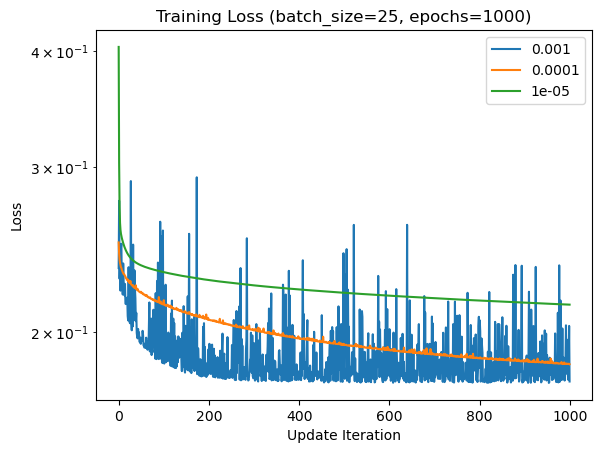

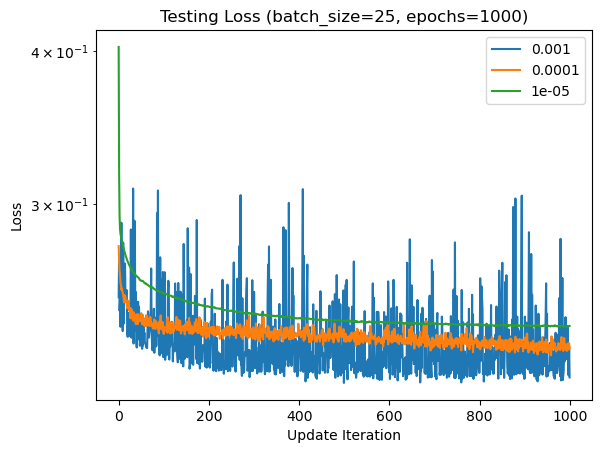

In [53]:
## Plot loss at different learning rates
lr = [1e-3, 1e-4, 1e-5]
plot_lr_loss_diff(lr, batch_size=25, epochs=1000, log_scale=False)

1/3: Batch size 10 took 18.700443029403687 seconds
2/3: Batch size 25 took 18.000861167907715 seconds
3/3: Batch size 50 took 17.35291814804077 seconds


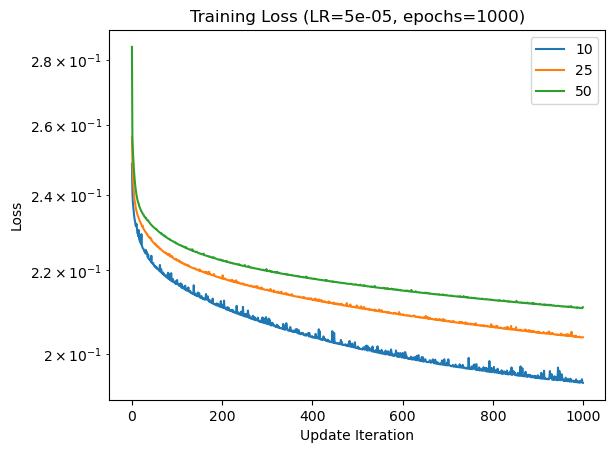

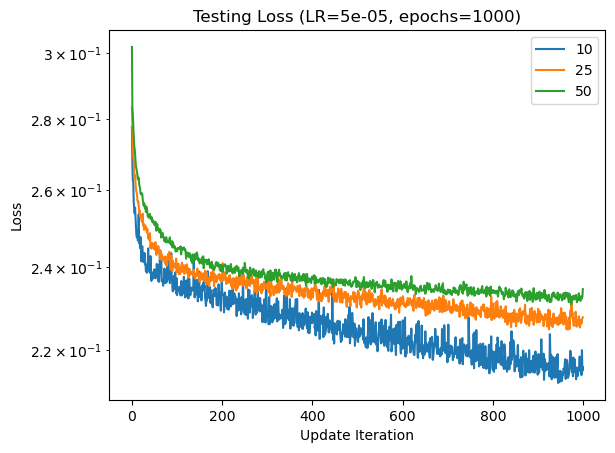

In [11]:
## Plot loss at different batch sizes
batch_sizes = [10, 25, 50]
plot_batch_size_loss_diff(batch_sizes, lr=5e-5, epochs=1000)

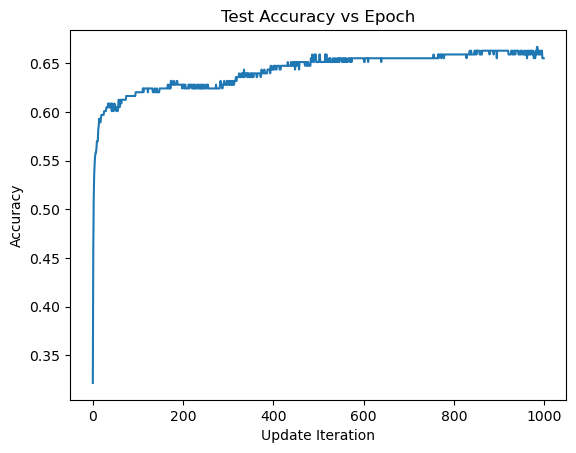

Wall time: 1min 1s


In [101]:
%%time
## Run Accuracy vs. Epoch Results (with shuffling of batches) and then take the maximum accuracy a and b values
## This is using the split set with 0/1 = 72/28 split so the learning rate is a result of the model just always picking 1
epochs = 10000
batch_size = 15
lr = 1e-5
a_max, b_max, epoch_max, accuracy = train_classifier(train_set, test_set, labels, inputs, epochs, batch_size, lr, return_accuracy=True)
plot_loss(accuracy,title="Test Accuracy vs Epoch", xlabel="Update Iteration", ylabel="Accuracy", log_scale=False, legend=False, single=True)

In [102]:
## Test accuracy on train_set
test_classifier(a_max, b_max, train_set, labels, inputs, to_print=True)

Positives=1909, Negatives=151


0.7087378640776699

In [103]:
## Test accuracy on test_set
test_classifier(a_max, b_max, test_set, labels, inputs, to_print=True)

Positives=242, Negatives=16


0.6666666666666666

In [104]:
## Test accuracy on validation_set
test_classifier(a_max, b_max, validation_set, labels, inputs, to_print=True)

Positives=232, Negatives=25


0.6653696498054474

In [ ]:
%%time
## Run Accuracy vs. Epoch Results (with shuffling of batches) and then take the maximum accuracy a and b values
## This time we're training on the 0/1 split 50/50 dataset to try to make the model choose evenly
epochs = 5000
batch_size = 15
lr = 1e-5
a_max, b_max, epoch_max, accuracy = train_classifier(train_set_5050, test_set, labels, inputs, epochs, batch_size, lr, return_accuracy=True)
plot_loss(accuracy,title="Test Accuracy vs Epoch", xlabel="Update Iteration", ylabel="Accuracy", log_scale=False, legend=False, single=True)

In [ ]:
## Test accuracy on train_set (with 72/28 split)
test_classifier(a_max, b_max, train_set, labels, inputs, to_print=True)

In [ ]:
## Test accuracy on test_set (with 72/28 split)
test_classifier(a_max, b_max, test_set, labels, inputs, to_print=True)

In [ ]:
## Test accuracy on validation_set (with 72/28 split)
test_classifier(a_max, b_max, validation_set, labels, inputs, to_print=True)